# <h1 align= 'center'>Gensim Word2Vec Embeddings</h1>

The goal for this analysis is to predict if a review rates the movie positively or negatively. Inside this dataset there are 25,000 labeled movies reviews for training, 50,000 unlabeled reviews for training, and 25,000 reviews for testing.
<a href="https://imgur.com/FfdEBRz"><img src="https://i.imgur.com/FfdEBRzm.png" title="source: imgur.com" align="right"></a>
- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- Contains 25000 positive and 25000 negative reviews
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)

> **Here, we use Gensim Word2Vec vectors to train a bag of centroids model to train machine learning models on.**

## <h2 align = "center" >Dependecies</h2>

In [4]:
import os
import re
import nltk
import time
import logging  
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn import preprocessing
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingClassifier as vc
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC as svc
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# read from local
# movies = pd.read_csv('data/imdb_data.csv')
# movies.sample(7)

In [6]:
# for importing data to colab
from google.colab import drive 
drive.mount('/content/drive')

movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/imdb_data.csv')
movies.sample(7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,review,sentiment
45882,Largely forgettable monster film from the 50s ...,negative
9120,"I'm a fan of good, plausible, action movies. A...",negative
37043,You know the story - a group of plucky no-hope...,positive
37290,This is one of the worst B slashers I've ever ...,negative
22188,This is possibly the single worst film i have ...,negative
36536,I think the romance of this movie helps couple...,positive
31401,"is it just me or have all ""horror"" movies beco...",negative


In [7]:
# Cateogrize positive and negative as 1 and 0 respectively

label_encoder = preprocessing.LabelEncoder()
movies['sentiment'] = label_encoder.fit_transform(movies['sentiment'])
movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
X = movies['review']
y = (np.array(movies['sentiment']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")
print

Train dataset shape: (40000,), 
Test dataset shape: (10000,)


<function print>

## <h2> <center>Preprocessing</center></h2>

In [9]:
!pip install contractions
!pip install textsearch
import contractions

In [0]:
def review_to_wordlist(review, custom = True, stem_words = True):
    # Clean the text, with the option to remove stopwords and stem words.
    
    # Strip html
    soup = BeautifulSoup(review, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    review_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    
    # replace accents
    review_text = unicodedata.normalize('NFKD', review_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    review_text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", review_text) # remove special characters
    review_text = contractions.fix(review_text) # expand contractions
    
    review_text = review_text.lower()
    words = review_text.split()
    if custom:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        stop_words.update(['movie', 'film', 'one', 'would', 'even', 
                           'movies', 'films', 'cinema',
                           'character', 'show', "'", "!", 'like'])
    else:
        stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_text = " ".join(words)
        
    review_text = re.sub(r"!", " ! ", review_text)
    review_text = re.sub(r"\?", " ? ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    
    if stem_words:
        words = review_text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in words]
        review_text = " ".join(stemmed_words)
    
    # Return a list of words, with each word as its own string
    return review_text.split()

In [0]:
def review_to_sentences(review):
    # Split a review into parsed sentences
    
    raw_sentences = sent_tokenize(review.strip())
    
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence))
    
    # Each sentence is a list of words, so this returns a list of lists
    return sentences

In [12]:
sentences = [] 

print ("Parsing sentences ...")
for review in movies['review']:
    sentences += review_to_sentences(review)

Parsing sentences


In [13]:
# Check how many sentences we have in total 
print (len(sentences))
print()
print (sentences[0])
print()
print (sentences[1])

536641

['review', 'mention', 'watch', '1', 'oz', 'episod', 'hook']

['right', 'exact', 'happen', 'first', 'thing', 'struck', 'oz', 'brutal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'go']


In [14]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300      # Word vector dimensionality                      
min_word_count = 5      # Minimum word count                        
num_workers = 1         # Number of threads to run in parallel
context = 20            # Context window size                                                                                    
downsampling = 1e-4     # Downsample setting for frequent words


# Initialize and train the model
print ("Training model...")
model = word2vec.Word2Vec(sentences, 
                          workers = num_workers,
                          size = num_features,
                          min_count = min_word_count,
                          window = context, 
                          sample = downsampling)

# Call init_sims because we won't train the model any further 
# This will make the model much more memory-efficient.
model.init_sims(replace=True)

# save the model for potential, future use.
model_name = "{}features_{}minwords_{}context".format(num_features,min_word_count,context)
model.save(model_name)

2020-06-15 08:49:58,755 : INFO : collecting all words and their counts
2020-06-15 08:49:58,756 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-15 08:49:58,786 : INFO : PROGRESS: at sentence #10000, processed 109778 words, keeping 12281 word types
2020-06-15 08:49:58,815 : INFO : PROGRESS: at sentence #20000, processed 212154 words, keeping 16957 word types
2020-06-15 08:49:58,848 : INFO : PROGRESS: at sentence #30000, processed 319839 words, keeping 20449 word types
2020-06-15 08:49:58,881 : INFO : PROGRESS: at sentence #40000, processed 428708 words, keeping 23465 word types
2020-06-15 08:49:58,912 : INFO : PROGRESS: at sentence #50000, processed 537485 words, keeping 26085 word types


Training model...


2020-06-15 08:49:58,944 : INFO : PROGRESS: at sentence #60000, processed 646687 words, keeping 28320 word types
2020-06-15 08:49:58,975 : INFO : PROGRESS: at sentence #70000, processed 753268 words, keeping 30256 word types
2020-06-15 08:49:59,008 : INFO : PROGRESS: at sentence #80000, processed 857437 words, keeping 31994 word types
2020-06-15 08:49:59,039 : INFO : PROGRESS: at sentence #90000, processed 964462 words, keeping 33724 word types
2020-06-15 08:49:59,072 : INFO : PROGRESS: at sentence #100000, processed 1073858 words, keeping 35321 word types
2020-06-15 08:49:59,104 : INFO : PROGRESS: at sentence #110000, processed 1177634 words, keeping 36826 word types
2020-06-15 08:49:59,137 : INFO : PROGRESS: at sentence #120000, processed 1284683 words, keeping 38314 word types
2020-06-15 08:49:59,169 : INFO : PROGRESS: at sentence #130000, processed 1392303 words, keeping 39769 word types
2020-06-15 08:49:59,200 : INFO : PROGRESS: at sentence #140000, processed 1500998 words, keeping

In [0]:
# Load the model, if necessary
# model = Word2Vec.load("300features_5minwords_20context") 

In [16]:
model.most_similar("great")

[('excel', 0.816072940826416),
 ('fantast', 0.7999541163444519),
 ('amaz', 0.7569818496704102),
 ('superb', 0.7192660570144653),
 ('fine', 0.718612790107727),
 ('terrif', 0.7167623043060303),
 ('phenomen', 0.7158746719360352),
 ('underr', 0.7157354354858398),
 ('ensembl', 0.7065820693969727),
 ('good', 0.7016606330871582)]

In [17]:
model.most_similar("stori")

[('simpl', 0.7496218085289001),
 ('weav', 0.7315472364425659),
 ('unfold', 0.727018415927887),
 ('intrigu', 0.7213847041130066),
 ('intertwin', 0.7189603447914124),
 ('straightforward', 0.7178325057029724),
 ('develop', 0.7149878740310669),
 ('woven', 0.7106461524963379),
 ('complex', 0.7090448141098022),
 ('arc', 0.7006566524505615)]

In [18]:
model.most_similar("bad")

[('horribl', 0.8426973223686218),
 ('terribl', 0.8389612436294556),
 ('aw', 0.8323017954826355),
 ('wors', 0.8209856748580933),
 ('suck', 0.8198513984680176),
 ('lousi', 0.8044291734695435),
 ('crappi', 0.7956873178482056),
 ('atroci', 0.7789114117622375),
 ('lame', 0.774627149105072),
 ('ok', 0.766001284122467)]

In [19]:
model.wv.syn0.shape

(26790, 300)

## <h2> <center>Bag of Centroids</center></h2>

In [20]:
# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.syn0 
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters,
                           n_init = 5,
                           verbose = 2)
idx = kmeans_clustering.fit_predict(word_vectors)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2397.1858
start iteration
done sorting
end inner loop
Iteration 1, inertia 2328.259
start iteration
done sorting
end inner loop
Iteration 2, inertia 2307.9102
start iteration
done sorting
end inner loop
Iteration 3, inertia 2298.8904
start iteration
done sorting
end inner loop
Iteration 4, inertia 2294.0745
start iteration
done sorting
end inner loop
Iteration 5, inertia 2291.3877
start iteration
done sorting
end inner loop
Iteration 6, inertia 2289.72
start iteration
done sorting
end inner loop
Iteration 7, inertia 2288.8457
start iteration
done sorting
end inner loop
Iteration 8, inertia 2288.4058
start iteration
done sorting
end inner loop
Iteration 9, inertia 2288.03
start iteration
done sorting
end inner loop
Iteration 10, inertia 2287.8965
start iteration
done sorting
end inner loop
Iteration 11, inertia 2287.776
start iteration
done sorting
end inner loop
Iteration 12, inertia 2287.66
start 

In [0]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number                                                                                            
word_centroid_map = dict(zip(model.wv.index2word, idx))

In [22]:
X = movies['review']
y = movies['sentiment']
# (np.array(movies['sentiment']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")

Train dataset shape: (37500,), 
Test dataset shape: (12500,)


In [23]:
# Clean the training and testing reviews.
clean_train_reviews = []
for review in X_train:
    clean_train_reviews.append(review_to_wordlist(review))
    
print("Training reviews are clean")  

clean_test_reviews = []
for review in X_test:
    clean_test_reviews.append(review_to_wordlist(review))
    
print("Testing reviews are clean") 

Training reviews are clean
Testing reviews are clean


In [0]:
def create_bag_of_centroids(wordlist, word_centroid_map):    
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max(word_centroid_map.values()) + 1
    
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    return bag_of_centroids

In [25]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((X_train.size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

print("Training reviews are complete.")    

Training reviews are complete.


In [26]:
# Repeat for test reviews 
test_centroids = np.zeros((X_test.size, num_clusters), dtype="float32")

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids(review, word_centroid_map )
    counter += 1
    
print("Testing reviews are complete.")  

Testing reviews are complete.


In [27]:
print(f"Train centroids shape: {train_centroids.shape}, \nTest centroids shape: {test_centroids.shape}")

Train centroids shape: (37500, 5358), 
Test centroids shape: (12500, 5358)


## <h2> <center>Modeling</center></h2>

In [0]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names  = ['Positive', 'Negative'], vmax=None,
                           normalized=True, title='Confusion matrix'):
    """
    Helper fuction to generate a clean Confusion Matrix using seaborn library.
    y_true: True labels, y_pred: Model Predictions, class_names: Override if needed
    normalized: True, gives the proportions instead of absolute numbers
    """
    matrix = confusion_matrix(y_true,y_pred)
    if normalized:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    annot_kws = {'fontsize':25, 
                'fontstyle': 'italic'}
    sns.heatmap(matrix, vmax=vmax, annot=True,  annot_kws = annot_kws,
                square=True, ax=ax, cbar=False,
                cmap=sns.diverging_palette(20, 250, as_cmap=True), 
                linecolor='black', linewidths=0.5,
                xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [29]:
lr_model = lr(C = 0.01,
              max_iter = 6,
              fit_intercept = True)

lr_model.fit(train_centroids, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
lr_pred = lr_model.predict(test_centroids)
print("Test set Accuracy: ", accuracy_score(lr_pred, y_test)*100)

Test set Accuracy:  85.736


2020-06-15 09:37:12,124 : INFO : NumExpr defaulting to 2 threads.


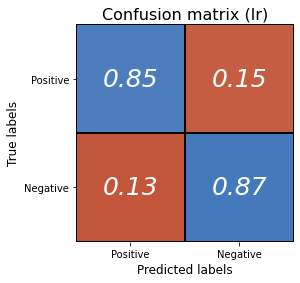

In [31]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, lr_pred, ax=axis1,
                       title='Confusion matrix (lr)')

In [32]:
svc_model = svc()

svc_model.fit(train_centroids, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [33]:
svc_pred = svc_model.predict(test_centroids)
print("Test set Accuracy: ", accuracy_score(svc_pred, y_test)*100)

Test set Accuracy:  85.648


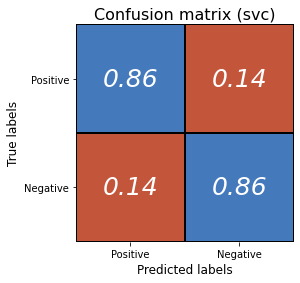

In [34]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, svc_pred, ax=axis1,
                       title='Confusion matrix (svc)')